# Trabajo Práctico 1: Propiedades en Venta

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste
- Polech, Facundo Agustin


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon

sns.set_theme()
sns.set_palette("colorblind")

caba_map = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')
dataframe_original = pd.read_csv("https://drive.usercontent.google.com/download?id=1FnqM4GcZ-2O8QOHA3F2UpjKPxhmoPhgv")

Nos encontramos con problemas para instalar la librería `pyclustertend` usada en las clases prácticas. Creemos que es por la versión de Python que utiliza. Optamos por tomar la parte de su código que vamos a usar.

Source: https://github.com/lachhebo/pyclustertend/blob/master/pyclustertend/hopkins.py

In [ ]:
from typing import Union
from sklearn.neighbors import BallTree


def hopkins(data_frame: Union[np.ndarray, pd.DataFrame], sampling_size: int) -> float:
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.

    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """

    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)

    data_frame_sample = sample_observation_from_dataset(data_frame, sampling_size)

    sample_distances_to_nearest_neighbours = get_distance_sample_to_nearest_neighbours(
        data_frame, data_frame_sample
    )

    uniformly_selected_observations_df = simulate_df_with_same_variation(
        data_frame, sampling_size
    )

    df_distances_to_nearest_neighbours = get_nearest_sample(
        data_frame, uniformly_selected_observations_df
    )

    x = sum(sample_distances_to_nearest_neighbours)
    y = sum(df_distances_to_nearest_neighbours)

    if x + y == 0:
        raise Exception("The denominator of the hopkins statistics is null")

    return x / (x + y)[0]


def get_nearest_sample(df: pd.DataFrame, uniformly_selected_observations: pd.DataFrame):
    tree = BallTree(df, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist
    return uniformly_df_distances_to_nearest_neighbours


def simulate_df_with_same_variation(
    df: pd.DataFrame, sampling_size: int
) -> pd.DataFrame:
    max_data_frame = df.max()
    min_data_frame = df.min()
    uniformly_selected_values_0 = np.random.uniform(
        min_data_frame[0], max_data_frame[0], sampling_size
    )
    uniformly_selected_values_1 = np.random.uniform(
        min_data_frame[1], max_data_frame[1], sampling_size
    )
    uniformly_selected_observations = np.column_stack(
        (uniformly_selected_values_0, uniformly_selected_values_1)
    )
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(
                min_data_frame[i], max_data_frame[i], sampling_size
            )
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)
    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)
    return uniformly_selected_observations_df


def get_distance_sample_to_nearest_neighbours(df: pd.DataFrame, data_frame_sample):
    tree = BallTree(df, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]
    return data_frame_sample_distances_to_nearest_neighbours


def sample_observation_from_dataset(df, sampling_size: int):
    if sampling_size > df.shape[0]:
        raise Exception("The number of sample of sample is bigger than the shape of D")
    data_frame_sample = df.sample(n=sampling_size)
    return data_frame_sample

# Análisis exploratorio y Preprocesamiento de Datos

## Exploración inicial

### Datos irrelevantes

Mantenemos un df de trabajo separado del original para mantener este último intacto.

In [ ]:
df = dataframe_original

Y le echamos un vistazo rápido al dataset.

In [ ]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

Observando la información de la tabla, notamos que toda la columna `place_l6` solamente contiene datos nulos. Algo similar sucede en el caso de `place_l5`, donde un muy alto porcentaje de filas no tienen ningún valor en esta columa.

In [ ]:
porcentaje_nulos_place_l5 = len(df[df["place_l5"].isna()]) / len(df) * 100
porcentaje_nulos_place_l6 = len(df[df["place_l6"].isna()]) / len(df) * 100

print("Porcenajes valores nulos por columna:\n")
print(f"place_l5: {round(porcentaje_nulos_place_l5, 2)}%")
print(f"place_l6: {porcentaje_nulos_place_l6}%")

Porcenajes valores nulos por columna:

place_l5: 99.47%
place_l6: 100.0%


Por lo tanto, se decidió eliminar ambas columnas.

In [ ]:
df = df.drop(["place_l5", "place_l6"], axis="columns")

Los únicos registros de propiedades que nos interesa analizar son los que cumple con las siguientes condiciones:

- Sean casas, departamentos o PHs
- Se encuentren en Capital Federal
- Estén en venta
- Su precio se encuentre en USD (dolares estadounidenses).

Con esto en mente, las columnas que nos interesan para el filtrado son `operation`, que indica las que están en venta; `property_currency`, que sería la moneda usada en el anuncio; y `property_type`, que muestra el tipo de propiedad.

In [ ]:
print("Valores únicos previos al filtrado:", end="\n\n")
print(f"operation: {df['operation'].unique()}")
print(f"property_currency: {df[df['property_currency'].notnull()]['property_currency'].unique()}")
print(f"property_type: {df['property_type'].unique()}")

Valores únicos previos al filtrado:

operation: ['Venta' 'Alquiler' 'Alquiler temporal']
property_currency: ['USD' 'UYU' 'ARS' 'PEN' 'COP']
property_type: ['Casa' 'PH' 'Departamento' 'Lote' 'Depósito' 'Otro' 'Local comercial'
 'Oficina' 'Casa de campo' 'Cochera']


In [ ]:
df = df[
    (df['operation'] == 'Venta') &
    (df['property_type'].isin(['Casa', 'PH', 'Departamento']))
]

Filtrar por el tipo de propiedad y de operación es bastante directo. Sin embargo, con el tipo de moneda, barajamos dos opciones de cómo manejar las propiedades que no están ingresada en USD: se podrían convertir los precios de los anuncios que no estén en USD a esa moneda, o directamente se podrían descartar todos estos registros. Antes de tomar una decisión seguimos explorando los datos un poco más.

Primero observamos que todas las propiedades de interés ya son de operaciones del tipo venta, por lo que esta columna no aporta mucho valor al dataset filtrado. Debido a esto se decide eliminar la columna entera.

In [ ]:
df['operation'].unique()

array(['Venta'], dtype=object)

In [ ]:
df = df.drop("operation", axis="columns")

Procediendo con el filtrado por ubicación de la propiedad, vemos que hay varias columnas nos dan información de la misma. Con lo cual, para quedarnos solo con los anuncios de Capital Federal, tenemos que indagar un poco que muestran las columnas `place_lk`, siendo `K` los distintos números de las columnas.

Para ello, buscamos una muestra que nos permita ver que valores tienen estas columnas.

In [ ]:
df[
    df['place_l2'].notnull() &
    df['place_l3'].notnull() &
    df['place_l4'].notnull()
][['place_l2', 'place_l3', 'place_l4']].sample(10)

,place_l2,place_l3,place_l4
152265,Bs.As. G.B.A. Zona Sur,Avellaneda,Avellaneda
206648,Buenos Aires Costa Atlántica,Mar del Plata,Centro
287412,Bs.As. G.B.A. Zona Sur,La Plata,La Plata
160838,Bs.As. G.B.A. Zona Norte,Pilar,La Lonja
146056,Bs.As. G.B.A. Zona Norte,San Miguel,San Miguel
150538,Capital Federal,Palermo,Palermo Soho
400749,Bs.As. G.B.A. Zona Norte,Escobar,Belén de Escobar
120314,Capital Federal,Palermo,Palermo Hollywood
235557,Bs.As. G.B.A. Zona Norte,Vicente López,Vicente López
378659,Bs.As. G.B.A. Zona Norte,Tigre,General Pacheco


En base a las muestras, apreciamos que a mayor `K`, mayor precisión en la ubicación. Capital Federal, siendo una zona muy extensa, está en las primera columna (`place_l2`). Las demás sirven para especificar barrio o región dentro de la ciudad en la que se encuentra cada propiedad.

In [ ]:
df['place_l2'].value_counts()

place_l2
Capital Federal                 95543
Bs.As. G.B.A. Zona Norte        53222
Santa Fe                        31815
Bs.As. G.B.A. Zona Sur          30489
Bs.As. G.B.A. Zona Oeste        20483
Córdoba                         13362
Buenos Aires Costa Atlántica     8443
Neuquén                          4345
Buenos Aires Interior            3365
Montevideo                       3051
Mendoza                          3042
Río Negro                        2851
Maldonado                        2766
Tucumán                          2352
Colonia                          1022
Salta                             958
Entre Ríos                        728
San Luis                          473
San Juan                          470
Canelones                         442
La Pampa                          418
Florida                           366
Chubut                            274
Misiones                          260
Michigan                          243
Corrientes                        173
Juj

In [ ]:
# Nos interesan únicamente las propiedades de Capital Federal
df = df[df['place_l2'] == 'Capital Federal']

De manera similar con como sucedió con la columna `operation`, luego de este último filtro, nos quedamos con propiedades cuyo `place_l2` únicamente toma el valor 'Capital Federal', por lo que eliminamos esta columna de valor único.

In [ ]:
df["place_l2"].unique()

array(['Capital Federal'], dtype=object)

In [ ]:
df = df.drop("place_l2", axis="columns")

Además, habiendo dejado únicamente `place_l3` y `place_l4` como variables de ubicación, vamos a renombrar estas mismas para darles nombres más significativos.

In [ ]:
df = df.rename({"place_l3": "neighbourhood", "place_l4": "sub_neighbourhood"}, axis="columns")

Ya con las propiedades fuera de Capital Federal filtradas, notamos que entre las propiedades restantes, aquellas cuyos precios no están en USD representan un pequeño porcentaje del total. Por lo que decidimos optar por eliminar estos registros.

In [ ]:
porcentaje_no_usd = len(df[df["property_currency"] != "USD"]) / len(df) * 100

print(f"Porcenajes monedas distintas de USD: {round(porcentaje_no_usd, 2)}%")

Porcenajes monedas distintas de USD: 1.35%


In [ ]:
df = df[df['property_currency'] == 'USD']

Nuevamente nos quedamos con un valor único en esta columna, por lo que ya no nos aporta mucha información de interés, y decidimos eliminarla.

In [ ]:
df["property_currency"].unique()

array(['USD'], dtype=object)

In [ ]:
df = df.drop("property_currency", axis="columns")

Continuando con la examinación de las variables del tipo fecha, notamos que en varios de los samples observados, el valor de la columna `start_date` y `created_on` coinciden. Por lo que exploramos más de detalle para ver qué tipo de información continen estas columnas.

In [ ]:
df[["start_date", "end_date", "created_on"]].sample(5)

,start_date,end_date,created_on
272411,2021-06-19,2021-06-19,2021-06-19
162340,2021-10-07,2022-01-27,2021-10-07
70597,2021-09-23,2021-09-26,2021-09-23
188001,2021-03-21,2021-03-23,2021-03-21
115410,2021-12-07,2022-01-27,2021-12-07


In [ ]:
df["start_date"].equals(df["created_on"])

True

Efectivamente para todos los registros los datos de estas dos columnas son los duplicados, por lo que decidimos prescindir de la columna `create_on`.

In [ ]:
df = df.drop("created_on", axis="columns")

Finalmente, evaluamos que hacer con la variable `property_title` ya que sus valores eran en su mayoría valores arbitrarios.

In [ ]:
df["property_title"].unique()

array(['VENTA CASA LLAVE EN MANO - COSTA ESMERALDA ',
       'VENTA TRES AMBIENTES LA BOCA PISO ALTO',
       'Departamento - 4 Ambientes - Catalinas Sur', ...,
       'Espectacular 4 amb130m2 con Balcon Terraza!!!',
       '3 ambientes con cochera listo para habitar!',
       'VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF C/ BALCÓN Vta Ata, PISO ALTO. BAJAS EXP. // APTO CRED.'],
      dtype=object)

Sin embargo, decidimos que podía aportar información importante a la hora de analizar outliers, así que momentáneamente la mantenemos.

Una vez hecho todo esto, echamos otros vistazo al dataframe ya procesado.

In [ ]:
df.sample(5)

,id,start_date,end_date,latitud,longitud,neighbourhood,sub_neighbourhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
190818,ErdmPyZQKoiOKda/Fp821A==,2021-11-01,2022-01-27,-31.361980,-64.340089,NaN,NaN,Casa,3.0,2.0,111.0,98.0,69000.0,Dúplex en Altos de la Calera - La Calera
65334,7+ZsbyK3m667PgwLkZ3JCQ==,2021-05-15,2021-07-09,-34.592696,-58.376691,Retiro,NaN,Departamento,5.0,4.0,181.0,173.0,450000.0,VENTA PISO EXCLUSIVO 5 AMBIENTES RETIRO
38534,38x9Do2U/oDTDhte/7yKqA==,2021-07-05,2022-02-09,-34.584825,-58.492123,Villa Pueyrredón,NaN,Departamento,1.0,NaN,63.0,35.0,99000.0,Monoambiente con espectacular terraza y cochera.
186862,0Sj/TUaTnctSIqPBh/29lg==,2021-05-25,2021-07-17,-34.583483,-58.474249,Parque Chas,NaN,Departamento,3.0,2.0,80.0,70.0,175000.0,Venta Depto 3 amb. c/balcon terraza V. Urquiza
171289,mZifWB4l3NP1MIcKtwyj8A==,2021-04-19,2021-08-07,-34.586951,-58.405373,Recoleta,NaN,Departamento,2.0,1.0,56.0,56.0,110000.0,VENTA DEPARTAMENTO 2 AMBIENTES PB EN RECOLETA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94249 entries, 25 to 460090
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        94249 non-null  object 
 1   start_date                94249 non-null  object 
 2   end_date                  94249 non-null  object 
 3   latitud                   90519 non-null  float64
 4   longitud                  90519 non-null  float64
 5   neighbourhood             93832 non-null  object 
 6   sub_neighbourhood         3643 non-null   object 
 7   property_type             94249 non-null  object 
 8   property_rooms            93205 non-null  float64
 9   property_bedrooms         83262 non-null  float64
 10  property_surface_total    89405 non-null  float64
 11  property_surface_covered  90895 non-null  float64
 12  property_price            94249 non-null  float64
 13  property_title            94249 non-null  object 
dtypes: float6

### Variable cuantitativas

Supuestos:
- Las unidades de medida de las variables `property_surface_total` y `property_surface_covered` son metros cuadrados.

Observamos las estadísticas de las columnas con datos cuantitativos.

In [ ]:
df.describe()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,90519.000000,90519.000000,93205.000000,83262.000000,89405.000000,90895.000000,9.424900e+04
mean,-34.591481,-58.449795,2.822799,2.014629,109.092970,87.931932,2.262382e+05
std,0.181719,0.292630,1.426148,1.129767,980.401976,990.927129,3.186035e+05
min,-53.788624,-71.471192,1.000000,-1.000000,10.000000,1.000000,5.000000e+03
25%,-34.615975,-58.466522,2.000000,1.000000,45.000000,40.000000,9.500000e+04
50%,-34.595790,-58.439000,3.000000,2.000000,65.000000,58.000000,1.439000e+05
75%,-34.577413,-58.408862,4.000000,3.000000,105.000000,88.000000,2.370000e+05
max,-24.219827,-54.133330,40.000000,70.000000,137000.000000,217000.000000,2.140000e+07


En base a estos datos, de inmediato se puede presentir la presencia de valores atípicos en todas las columnas de carácter numérico, salvo en longitud y latitud. Si observamos los máximos de las variables, vemos que estos valores están muy desviados de la media y del percentil 75% de sus respectivas variables.

Así mismo, si observamos los mínimos, notamos que en la columna `property_bedrooms` hay valores negativos, que claramente es un valor inválido, y también en la columna `property_rooms` el valor mínimo es solo 1, es decir, una propiedad que solo tiene 1 habitación. Optamos por interpretar este tipo de propiedades como un monoambiente.

También podemos notar que hay propiedades con superficies mayores a 100,000 metros cuadrados, lo que sería mayor al área que abarcan 14 campos de fútbol. Estos valores atípicos serán revisados con detenimiento más adelante, pero desde ya podemos intuir que estando en Capital Federal es díficil que estos valores sean correctos.

#### Correlación entre variables

Usamos un pairplot para empezar a ver las relaciones entre las distintas variables del dataset. Quitamos de este análisis la latitud y la longitud porque como refieren a coordenadas geográficas, sus valores numéricos no guardan relación lógica con el resto de los datos.

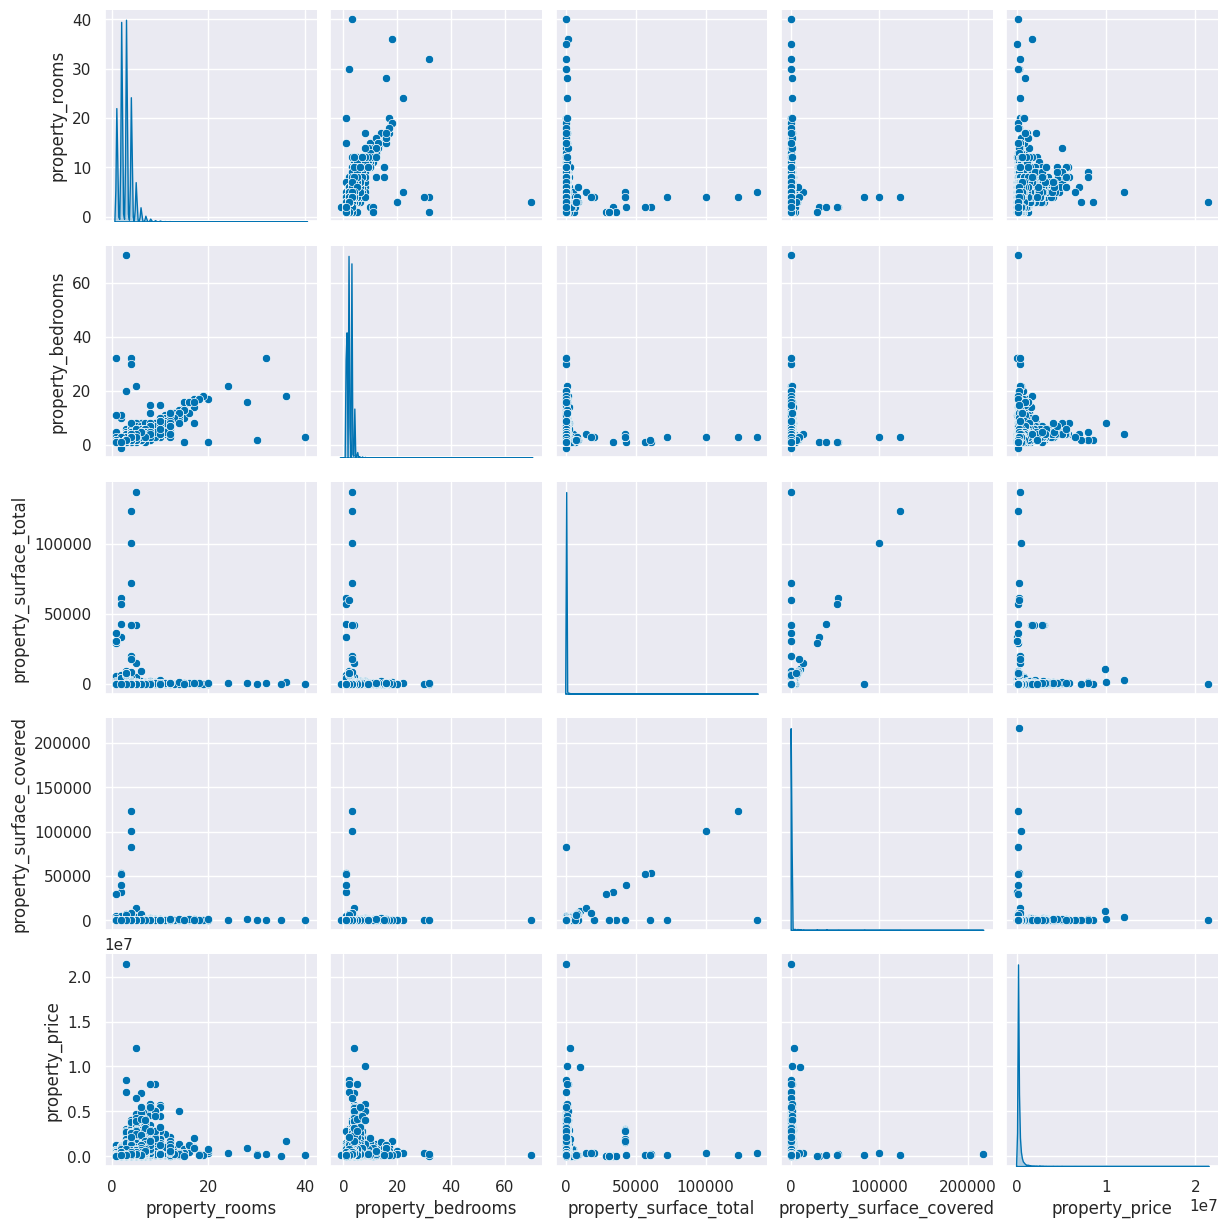

In [ ]:
# Utilizamos un diagrama de distribución en vez de un histograma para reducir el tiempo de cómputo.
# Igualmente nos dan a entender la misma idea en este caso.

sns.pairplot(data=df.drop(["latitud", "longitud"], axis="columns"), diag_kind="kde")

Llama la atención que varios de los gráficos de disperción entre variables son de "larga cola", lo que podría estar reafirmando la sospecha de la presencia de valores atípicos. Esto es especialmente evidente en los histogramas en la diagonal que grafican a cada variable consigo misma, donde pareciera haber un rango significativo de valores dispersos.

Analizamos la correlación entre variables utilizando el coeficiente de correlación de Pearson.

<Axes: title={'center': 'Correlación entre variables numéricas'}>

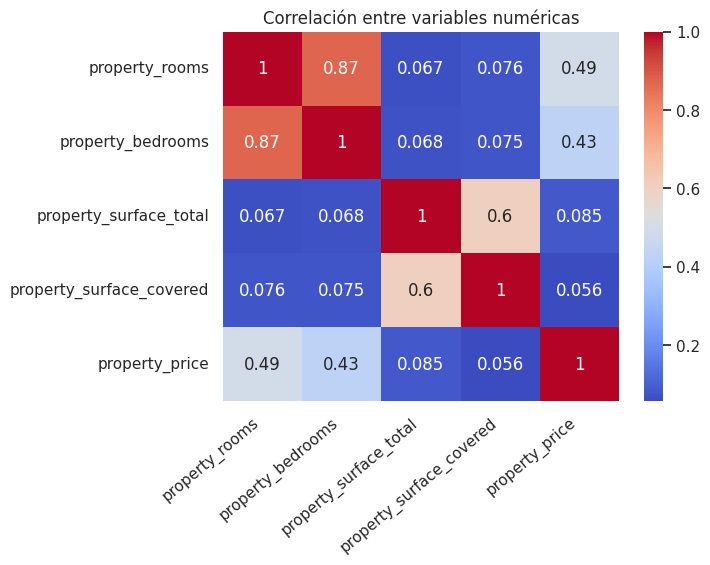

In [ ]:
correlaciones = sns.heatmap(data=df.drop(["latitud", "longitud"], axis=1).select_dtypes("number").corr(), annot=True, cmap="coolwarm")
correlaciones.set(title="Correlación entre variables numéricas")
correlaciones.set_xticks(correlaciones.get_xticks()) # Evita un warning de Matplotlib con el siguiente comando.
correlaciones.set_xticklabels(correlaciones.get_xticklabels(), rotation=40, ha="right")

correlaciones

Lo más notorio en cuanto a correlaciones entre variables antes de hacer manejo de valores atípicos y datos nulos, es que relación entre las variables `property_rooms` y `property_bedrooms`. Es sensato pensar que las propiedades con más habitaciones tienen más cuartos y viceversa. Además, estas mismas dos variables son las que más se relacionan (linealmente) con el precio de la propiedad.

### Variable cualitativas

Las variables cualitativas con las que contamos son variables de texto y fecha. Son del tipo nominales, es decir, variables que pueden ser consideradas como opciones de categorías pero que no tienen un orden específico. Las columnas en cuestión son: `start_date`, `end_date`, `place_l3`, `place_l4` y `property_type`.

In [ ]:
df.select_dtypes("object").drop("id", axis="columns")

,start_date,end_date,neighbourhood,sub_neighbourhood,property_type,property_title
25,2021-09-09,2021-09-26,NaN,NaN,Casa,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,2021-09-09,2021-09-26,Boca,NaN,Departamento,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,2021-09-09,2021-09-28,Boca,NaN,Departamento,Departamento - 4 Ambientes - Catalinas Sur
49,2021-09-09,2022-01-05,Once,NaN,Departamento,Venta departamento 4 ambientes Once
51,2021-09-09,2022-03-09,Boedo,NaN,PH,PH - Boedo
...,...,...,...,...,...,...
460072,2021-01-05,2022-09-02,Villa del Parque,NaN,Departamento,Espectacular 4 amb130m2 con Balcon Terraza!!!
460073,2021-01-05,2021-02-17,Villa del Parque,NaN,Departamento,3 ambientes con cochera listo para habitar!
460074,2021-01-05,2021-01-27,Villa del Parque,NaN,Departamento,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...
460075,2021-01-05,2021-01-27,Villa del Parque,NaN,Departamento,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...


Examinando las variables del tipo fecha podemos observar que tenemos 365 fechas únicas. Todas son del año 2021, lo que significa que hubieron nuevas propiedades enlistadas para venta todos los días del año.

In [ ]:
print(f"Cantidad fechas únicas: {len(df['start_date'].unique())}")

Cantidad fechas únicas: 365


In [ ]:
pd.to_datetime(df["start_date"]).apply(lambda x: x.year).unique()

array([2021])

Sin embargo, con los valores de la variable `end_date` hay un rango de fechas mucho más amplio, en el que incluso llegamos a encontrar fechas del año 9999.

In [ ]:
df[df["end_date"].str.contains("9999")]["end_date"]

1233      9999-12-31
1471      9999-12-31
1495      9999-12-31
1520      9999-12-31
1932      9999-12-31
             ...    
460015    9999-12-31
460019    9999-12-31
460020    9999-12-31
460028    9999-12-31
460065    9999-12-31
Name: end_date, Length: 5041, dtype: object

Interpretamos estos valores como registros que todavía seguían listados al momento de generar el dataset, es decir, propiedades que todavía no se habían vendido. La gran cantidad de casos en los que pasa esto descarta posibles errores en el ingreso de esos datos.

En cuanto los valores de la variable `barrio`, podemos observar los valores posibles y sus frecuencias:

In [ ]:
df["neighbourhood"].value_counts()

neighbourhood
Palermo                 14308
Belgrano                 8898
Caballito                7168
Recoleta                 6282
Villa Urquiza            4673
Almagro                  4081
Nuñez                    3546
Villa Crespo             3189
Flores                   3110
Barrio Norte             2975
Balvanera                2553
Colegiales               1951
Villa Devoto             1921
Villa del Parque         1829
Saavedra                 1829
Puerto Madero            1493
San Telmo                1380
San Cristobal            1300
San Nicolás              1295
Retiro                   1250
Barracas                 1246
Boedo                    1237
Floresta                 1195
Monserrat                1115
Parque Chacabuco         1073
Villa Pueyrredón         1011
Coghlan                   984
Villa Luro                727
Mataderos                 719
Chacarita                 697
Liniers                   668
Villa Ortuzar             662
Parque Patricios          

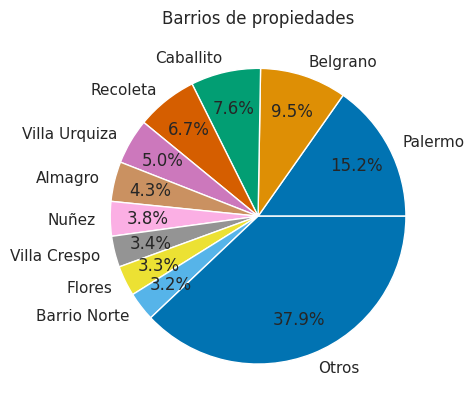

In [ ]:
frecuencias_barrios = df["neighbourhood"].value_counts().sort_values(ascending=False)
top_k_barrios = 10

barrios_mas_comunes = frecuencias_barrios.iloc[:top_k_barrios]
barrios_mas_comunes["Otros"] = frecuencias_barrios.iloc[top_k_barrios:].sum()

plt.pie(barrios_mas_comunes, labels=barrios_mas_comunes.index,
        autopct="%1.1f%%", pctdistance=0.75)
plt.title(label="Barrios de propiedades")
plt.show()

En cuanto a los sub-barrios podemos ver que solamente aquellas propiedades que se encuentran en Palermo tienen información sobre el subbarrio en el que se encuentran.

In [ ]:
sub_barrios = df[df["sub_neighbourhood"].notnull()]["sub_neighbourhood"].value_counts()
sub_barrios

sub_neighbourhood
Palermo Hollywood    1576
Palermo Chico        1092
Palermo Soho          804
Palermo Viejo         171
Name: count, dtype: int64

In [ ]:
porcentaje_con_sub_barrios = sub_barrios.sum() / len(df) * 100

print(f"Porcentaje propiedades con sub-barrio: {round(porcentaje_con_sub_barrios, 2)}%")

Porcentaje propiedades con sub-barrio: 3.87%


Finalmente, si analizamos el campo `property_type` que filtramos anteriormente para solo tener propiedades de los tipos 'Casa', 'PH' o 'Departamento' tiene las siguientes métricas:

In [ ]:
df["property_type"].value_counts()

property_type
Departamento    80829
PH               9266
Casa             4154
Name: count, dtype: int64

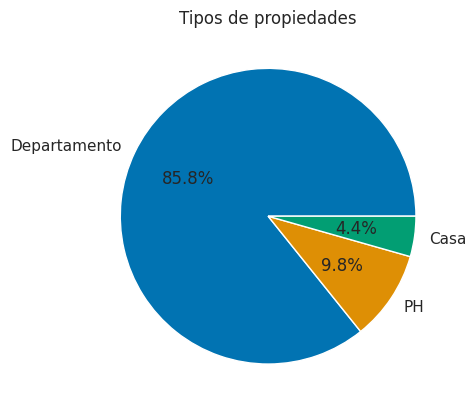

In [ ]:
property_types = df["property_type"].value_counts()

plt.pie(property_types, labels=property_types.index,
        autopct="%1.1f%%")
plt.title(label="Tipos de propiedades")
plt.show()

## Limpieza de datos

### Datos faltantes y Outliers



Observamos los porcentajes de datos nulos por columna:

In [ ]:
porcentajes_nulos = df.isna().sum() / len(df) * 100
porcentajes_nulos = porcentajes_nulos[porcentajes_nulos > 0]
porcentajes_nulos

latitud                      3.957602
longitud                     3.957602
neighbourhood                0.442445
sub_neighbourhood           96.134707
property_rooms               1.107704
property_bedrooms           11.657418
property_surface_total       5.139577
property_surface_covered     3.558658
dtype: float64

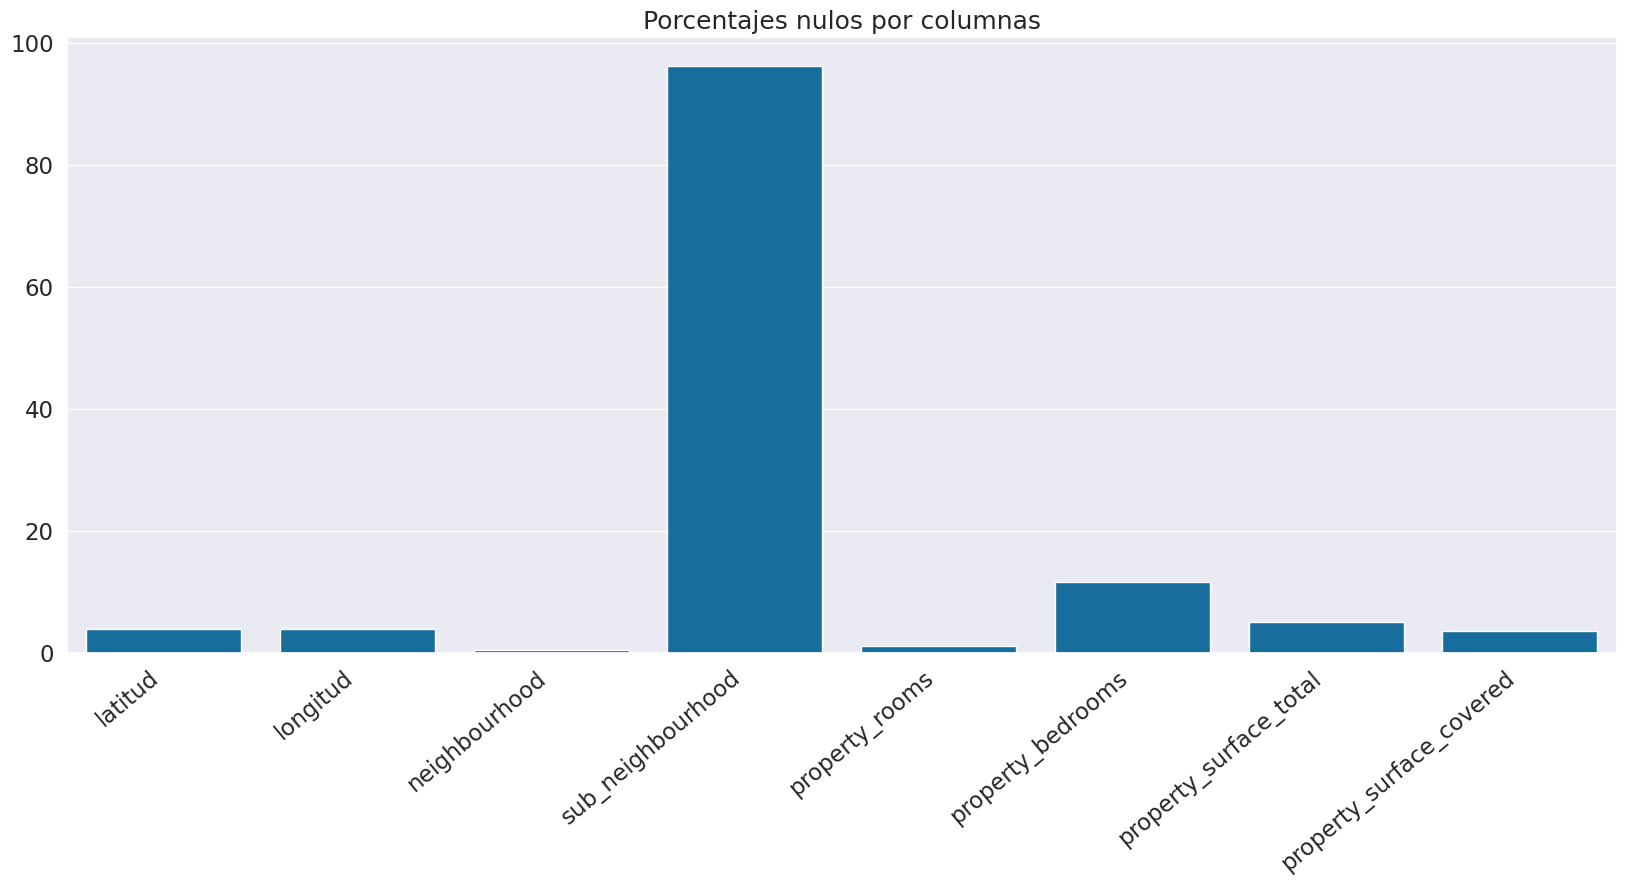

In [ ]:
plt.figure(figsize=(20,8))
with sns.plotting_context("notebook", font_scale=1.5):
  porcentajes_nulos_grafico = sns.barplot(porcentajes_nulos)
  porcentajes_nulos_grafico.set(title="Porcentajes nulos por columnas")
  porcentajes_nulos_grafico.set_xticks(porcentajes_nulos_grafico.get_xticks()) # Evita un warning de Matplotlib con el siguiente comando.
  porcentajes_nulos_grafico.set_xticklabels(porcentajes_nulos_grafico.get_xticklabels(), rotation=40, ha="right")

Podríamos analizar lo mismo pero a nivel de fila, es decir, determinar cuántas filas tienen solo 1 columna nula, cuántas tiene 2, cuántas tiene todas las columnas nulas, etc.

In [ ]:
porcentajes_nulos_por_fila = df.isna().sum(axis="columns").value_counts() / len(df) * 100
porcentajes_nulos_por_fila

1    75.502127
2    16.618744
3     4.359728
0     2.568728
4     0.727859
5     0.112468
6     0.109285
7     0.001061
Name: count, dtype: float64

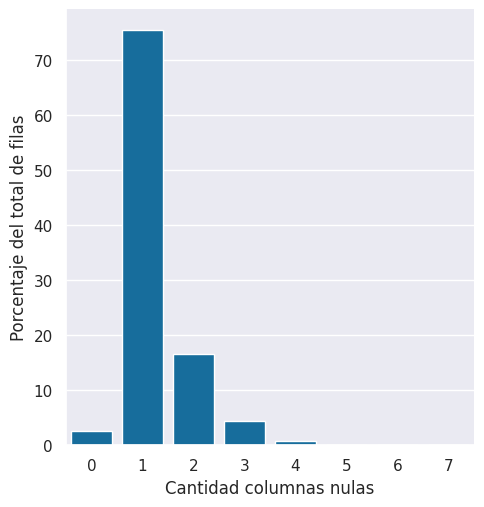

In [ ]:
sns.catplot(data=porcentajes_nulos_por_fila, kind="bar").set(xlabel="Cantidad columnas nulas",
                                                            ylabel="Porcentaje del total de filas")

Es decir, que la mayoría de los registros que contienen columnas nulas tiene solamente 1 columna nula.

#### Barrios

Sabemos de los análisis anteriores que un alto porcentaje de propiedades tienen solamente 1 columna con datos nulos, y que a la vez, muchos registros tienen la columna `sub_neighbourhood` también sin datos, por lo que podríamos ver si este alto porcentaje de registros con solo 1 columna nula se debe a sus valores para este último campo.

In [ ]:
cantidad_con_1_col_nula = df.isna().sum(axis="columns").value_counts()[1]
cantidad_solo_sub_neighbourhood_nulo = len(df[
    (df.isna().sum(axis="columns") == 1) &
    (df["sub_neighbourhood"].isna())
])

print(f"Porcentaje con solo `sub_neighbourhood` nulo: {round(cantidad_solo_sub_neighbourhood_nulo / cantidad_con_1_col_nula * 100, 2)}%")

Porcentaje con solo `sub_neighbourhood` nulo: 98.99%


Efectivamente, casi el 99% de los registros a los que les falta solo una feature (conjunto que a su vez representa al casi 75% de los registros con nulos totales) son propiedades que no tienen información sobre el sub-barrio en el que se encuentran. Debido a esto, decidimos eliminar esta columna también.

In [ ]:
df = df.drop("sub_neighbourhood", axis="columns")

Por otra parte, el poncentaje de propiedades que no tienen información de su barrio es bajo. Sabiendo que tenemos información sobre la latitud y longitud de las mismas, podríamos completar la información del barrio que falta en una propiedad si contamos con sus coordenadas. Para esto vamos a utilizar la información provista por el Gobierno de la Ciudad mediante [este dataset](https://data.buenosaires.gob.ar/dataset/barrios) y aplicar la técnica Cold-Deck.

In [ ]:
barrios = pd.read_csv("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.csv", delimiter=";")[["BARRIO", "WKT"]]
barrios["WKT"] = barrios["WKT"].apply(wkt.loads)

barrios = gpd.GeoDataFrame(barrios, geometry="WKT").rename({"BARRIO": "neighbourhood"}, axis="columns")

Tenemos que cambiar los nombres de los barrios en el dataset del gobierno para que coincidan con los nombres de los barrios que ya tenemos, para que no se introduzcan nuevas variantes para esta categoría cuando se está intentando representar el mismo barrio.

In [ ]:
barrios["neighbourhood"] = barrios["neighbourhood"].apply(lambda x: x.title())

barrios_gcba = set(barrios["neighbourhood"].unique())
barrios_properati = set(df[df["neighbourhood"].notnull()]["neighbourhood"].unique())

display(barrios_properati.difference(barrios_gcba)) # Están en el ds de Properati pero no en el de GCBA
display(barrios_gcba.difference(barrios_properati)) # Están en el ds de GCBA pero no en el de Properati

{'Abasto',
 'Agronomía',
 'Barrio Norte',
 'Catalinas',
 'Centro / Microcentro',
 'Congreso',
 'Constitución',
 'Las Cañitas',
 'Once',
 'Parque Centenario',
 'Pompeya',
 'San Nicolás',
 'Tribunales',
 'Villa General Mitre',
 'Villa Pueyrredón',
 'Villa del Parque'}

{'Agronomia',
 'Constitucion',
 'Nueva Pompeya',
 'San Nicolas',
 'Villa Del Parque',
 'Villa Gral. Mitre',
 'Villa Pueyrredon'}

In [ ]:
barrios["neighbourhood"] = barrios["neighbourhood"].replace({
  "Agronomia": "Agronomía",
  "Constitucion": "Constitución",
  "San Nicolas": "San Nicolás",
  "Villa Del Parque": "Villa del Parque",
  "Villa Gral. Mitre": "Villa General Mitre",
  "Villa Pueyrredon": "Villa Pueyrredón"
})

In [ ]:
from shapely.geometry import Point

def asignar_barrio(propiedad):
  latitud, longitud = propiedad["latitud"], propiedad["longitud"]
  barrios.contains(Point(longitud, latitud))
  try:
    propiedad["neighbourhood"] = barrios[barrios.contains(Point(longitud, latitud))]["neighbourhood"].iloc[0]
  except IndexError:
    pass

  return propiedad

In [ ]:
df = df.apply(lambda p: p if not pd.isna(p["neighbourhood"]) else asignar_barrio(p), axis="columns")

Luego de aplicar la técnica de Cold-Deck, vemos que aún nos queda ciertas filas con barrios nulos. Con lo cual, procedemos a ver cuantas de esas filas tampoco tienen coordenadas válidas.

In [ ]:
df['neighbourhood'].isna().value_counts()

neighbourhood
False    93883
True       366
Name: count, dtype: int64

In [ ]:
len(df[df['neighbourhood'].isna() & ((df['latitud'].isna()) | (df['longitud'].isna()))])

170

De las 366 filas que no tienen barrio, 170 tampoco tienen longitud o latitud, por lo que decidimos dropearlas.

In [ ]:
porcentajes_nulos_neighbourhood = df['neighbourhood'].isna().sum() / len(df) * 100
porcentajes_nulos_neighbourhood

0.3883330327112224

In [ ]:
df = df.dropna(subset=['neighbourhood'])

Sin embargo, todavía nos quedan algunas propiedades que tienen información del barrio, pero no tienen información de su latitud ni longitud. Lo que vamos a hacer para estas propiedades es ubicarlas en el centro de sus respectivos barrios.

In [ ]:
cantidad_sin_coords = len(df[(df['latitud'].isna() | df['longitud'].isna())])
print("Cantidad con barrios sin coordenadas antes de Cold-Deck:", cantidad_sin_coords)

Cantidad con barrios sin coordenadas antes de Cold-Deck: 3560


In [ ]:
barrios_con_centro = barrios.copy()
barrios_con_centro["centro"] = barrios.centroid

def asignar_coordenadas(propiedad):
  barrio = propiedad["neighbourhood"]

  try:
    centro = barrios_con_centro[barrios_con_centro["neighbourhood"] == barrio]["centro"]
    propiedad["latitud"], propiedad["longitud"] = centro.get_coordinates().values[0]
  except IndexError:
    pass

  return propiedad

In [ ]:
df = df.apply(lambda p: asignar_coordenadas(p) if pd.isna(p["latitud"]) or pd.isna(p["longitud"]) else p, axis="columns")

Sin bien no se logró encontrar el centro de coordenadas de todos los barrios de las propiedades de Properati, se redujo la cantidad de registros con latitud y longitud nulos de 3560 a 309, lo cual es una reducción significativa.

In [ ]:
cantidad_sin_coords = len(df[(df['latitud'].isna() | df['longitud'].isna())])
print("Cantidad con barrios sin coordenadas después de Cold-Deck:", cantidad_sin_coords)

Cantidad con barrios sin coordenadas después de Cold-Deck: 309


Si observamos algunos de los nombres de los barrios de las propiedades a las que no se les pudo asignar coordenadas, podemos observar que son nombres de subbarrios en vez de nombres oficiales de barrios reconocidos por el Gobierno de la Ciudad. Podríamos haber asignado a estos subbarrios las coordenadas de sus verdaderos barrios o haberles cambiado el nombre para unificarlos con los mismo, pero debido a que el número de propiedades es muy bajo en comparación con las propiedades a las que sí se les asignó un centro de coordenadas, decidimos mejor dropear estas faltantes.

In [ ]:
df[(df["latitud"].isna()) | (df["longitud"].isna())]["neighbourhood"].value_counts()

neighbourhood
Barrio Norte            185
Congreso                 39
Once                     36
Tribunales               32
Abasto                   12
Pompeya                   3
Parque Centenario         1
Centro / Microcentro      1
Name: count, dtype: int64

In [ ]:
df = df.dropna(subset=["longitud", "latitud"])

#### Áreas

Examinamos que sucede con las propiedades que no tienen `property_surface_total` ni `property_surface_covered`. Los porcentajes de registros que tienen nulo alguna de estas dos columnas son 5.09% y 3.56% respectivamente.

In [ ]:
porcentaje_surface_total_na = round(len(df[df['property_surface_total'].isna()]) / len(df) * 100, 2)
porcentaje_surface_surface_na = round(len(df[df['property_surface_covered'].isna()]) / len(df) * 100, 2)

porcentaje_surface_total_na, porcentaje_surface_surface_na

(5.09, 3.56)

Vemos que hay 184 propiedades cuya superficie cubierta es mayor que la superficie total, y como esto no tiene sentido y ademas son pocas decidimos dropearlas.

In [ ]:
df = df.drop(df[df['property_surface_covered'] > df['property_surface_total']].index)

Optamos por utilizar la técnica MICE completar los valores faltantes de estas dos columnas.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_surfaces = IterativeImputer(random_state=0)
df = df.copy()
df.loc[:, ["property_surface_total", "property_surface_covered"]] = impute_surfaces.fit_transform(df[["property_surface_total", "property_surface_covered"]])

Visualizamos los outliers de estas dos variables.

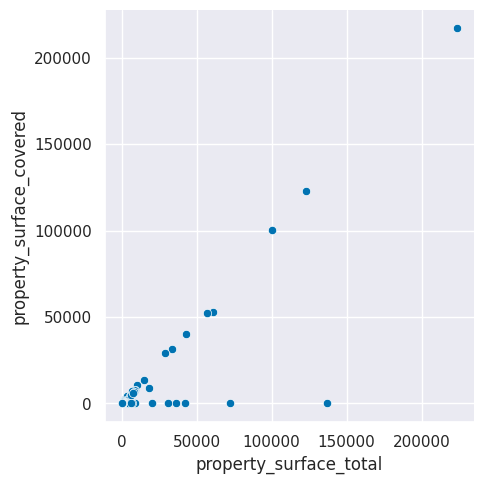

In [ ]:
sns.relplot(data=df, x="property_surface_total", y="property_surface_covered", kind="scatter")

<Axes: ylabel='property_surface_covered'>

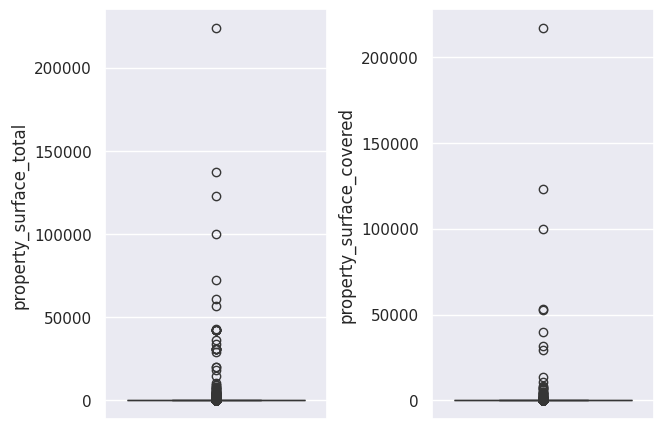

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout(w_pad=3)

sns.boxplot(y=df['property_surface_total'], ax=ax[0])
sns.boxplot(y=df['property_surface_covered'], ax=ax[1])

Observando los gráficos de dispersión y los boxplots de cada una de las variables podemos observar la presencia de outliers en ambas, con propiedades que probablemente tengan outliers en ambas, como muestra el primero de los graáficos.

Analizamos las estadísticas de estas variables para tener más información.

In [ ]:
df[["property_surface_total", "property_surface_covered"]].describe()

,property_surface_total,property_surface_covered
count,93390.000000,93390.000000
mean,110.200940,86.183560
std,1190.274960,938.974643
min,10.000000,1.000000
25%,45.000000,40.000000
50%,66.000000,57.000000
75%,105.000000,88.000000
max,223842.217161,217000.000000


Al ver las estadísticas llaman la atención los extremos de ambas variables. Por ejemplo, podemos graficar el punto más aislado que visualizamos en el scatter plot anterior.

In [ ]:
df[df["property_surface_total"] == df["property_surface_total"].max()][["property_type", "property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_title"]]

,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_title
1932,Casa,NaN,NaN,223842.217161,217000.0,EXCEPCIONAL CASA DOS FAMILIAS - Parque Chacabuco


Ninguno de los valores de esta propiedad tienen sentido, por lo que decidimos dropearla.

In [ ]:
df = df.drop(1932)

En base a los boxplots, podemos ver que hay un conjunto de propiedades que tiene sus valores de superficie particularmente altos, así que echamos un vistazo a las propiedades con `property_surface_total` y `property_surface_covered` más altos.

In [ ]:
df[df["property_surface_total"] > 20000]

,id,start_date,end_date,latitud,longitud,neighbourhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
72316,BPTyNzwU2D4btCduu8ls3A==,2021-05-29,2021-06-08,-34.578917,-58.429373,Palermo,Departamento,2.0,1.0,61130.0,53030.0,225000.0,VENTA DEPARTAMENTO 2 AMBIENTES PALERMO C/AMENI...
72521,csbBJk04jQXgGZLXTj5WAg==,2021-05-29,2021-06-13,-34.600113,-58.403649,Balvanera,Departamento,2.0,1.0,33800.0,31670.0,66000.0,VENTA 2 AMBIENTES CON RENTA
84073,vMD1fCSS0kedOs8Bk/PCjA==,2021-02-05,2021-05-16,-34.588175,-58.396261,Recoleta,Departamento,1.0,NaN,36000.0,30.0,90000.0,Departamento Monoambiente alquiler temporario ...
106598,+YPtNPAzbhoDCLgqF26Q8A==,2021-03-11,2021-04-20,-34.587320,-58.401556,Barrio Norte,Departamento,2.0,1.0,56740.0,52540.0,175000.0,EXCELENTE DEPARTAMENTO DE 2 AMBIENTES DE CATEG...
117835,vyRPw0ch6cIj9Ki5yPUneA==,2021-08-18,2021-08-23,-34.550093,-58.483034,Saavedra,Departamento,2.0,1.0,43086.0,40038.0,114000.0,"Venta Departamento 2 amb a Estrenar, Saavedra."
126869,MYZD6oNPlLhMzVLoEbL9jw==,2021-10-05,2021-11-04,-34.579163,-58.455725,Colegiales,Departamento,1.0,NaN,31000.0,26.0,51100.0,Av. Alvarez Thomas 970 - Colegiales - Capital ...
129214,tJ7TjXeyIl+4KPkaPqyAYA==,2021-07-01,9999-12-31,-34.599421,-58.386867,Barrio Norte,Departamento,5.0,3.0,137000.0,135.0,390000.0,Alquiler Divino 5 Amb. - 137 M² en Barrio Norte
219021,WQU6YIN+y4z30xaPRG4LHQ==,2021-03-07,2022-02-09,-34.636532,-58.376406,Barracas,Departamento,4.0,3.0,72060.0,90.0,210000.0,"VENTA SEMIPISO 4 AMBIENTES, EXCELENTE OPORTUIDAD"
237392,wGXDCrWhpDX+JQBrC+7jpA==,2021-02-27,2021-03-03,-34.628721,-58.421383,Boedo,PH,4.0,3.0,20041.0,139.0,390000.0,PH 4 AMB.C/QUINCHO Y TERRAZA AL FRENTE S/EXPENSAS
275253,5nXtCXuxHhkZ51syuRB7YQ==,2021-09-15,2021-10-07,-34.579163,-58.455725,Colegiales,Departamento,1.0,NaN,31000.0,26.0,51100.0,Av. Alvarez Thomas 970 - Colegiales - Capital ...


Entre estos registros destacamos el que tiene valor de área total de 137000 metros cuadrados, que podría deberse a un error en momento de cargar el registro de la propiedad, ya que los tres primeros dígitos de este número se asemejan a los dígitos del valor de `property_surface_covered`. Si efectivamente nos fijamos en la descripción de la propiedad, ahí mismo se menciona que el área de la propiedad es 137 metros cuadrados, por lo tanto, corregimos el registro.

In [ ]:
df.loc[129214, "property_surface_total"] = 137

Podría suceder algo similar en la propiedad de Villa Urquiza que tiene 123000 metros cuadrados. El valor que se quizo haber agregado podría ser 123. Consideramos esto como un error, y por lo tanto, lo enmendamos.

In [ ]:
df.loc[405324, "property_surface_total"] = 123
df.loc[405324, "property_surface_covered"] = 123

Y también en la propiedad de Recoleta con 36000 metros totales y solamente 30 cubiertos. Además, sabemos que esta propiedad es un monoambiente por su descripción, por lo que que tenga entre 30 y 40 metros de área tiene sentido, así que corregimos este registro también.

In [ ]:
df.loc[84073, "property_surface_total"] = 36

También observamos un grupo de propiedades que por su descripción parecieran ser todas del mismo edificio (Av. Alvarez Thomas 970 - Colegiales). Todas tienen el mismo valor tanto en el campo `property_surface_total` y `property_surface_covered`, y el valor de esta primera variable pareciera sufrir de un error similar a los anteriores, donde los primeros dígitos del `property_surface_total` (que vale 31000) se asemejan a los primeros dígitos de la segunda variable (26). Por lo tanto, corregimos estos ingresos.

Observando otras propiedades en este mismo edificio, vemos que hay bastantes que efectivamente tienen 31 metros cuadrados de área.

In [ ]:
esta_en_edificio_alvarez_thomas = df["property_title"].str.contains("Av. Alvarez Thomas 970 - Colegiales - Capital")
df[(esta_en_edificio_alvarez_thomas) & (df["property_surface_total"] == 31)].head()[["property_surface_total",	"property_surface_covered",	"property_title"]]

,property_surface_total,property_surface_covered,property_title
79363,31.0,26.0,Av. Alvarez Thomas 970 - Colegiales - Capital ...
79366,31.0,26.0,Av. Alvarez Thomas 970 - Colegiales - Capital ...
126871,31.0,26.0,Av. Alvarez Thomas 970 - Colegiales - Capital ...
215581,31.0,26.0,Av. Alvarez Thomas 970 - Colegiales - Capital ...
215586,31.0,26.0,Av. Alvarez Thomas 970 - Colegiales - Capital ...


In [ ]:
df.loc[(esta_en_edificio_alvarez_thomas) & (df["property_surface_total"] == 31000), "property_surface_total"] = 31

Podría estar pasando lo mismo con los departamentos cuya descripción contienen 'Reventa - Departamento - Palermo Nuevo'. El valor real de este campo para todos estos registros podría ser de 421.

In [ ]:
esta_en_edificio_palermo_nuevo = df["property_title"].str.contains("Reventa - Departamento - Palermo Nuevo")
df[esta_en_edificio_palermo_nuevo]

,id,start_date,end_date,latitud,longitud,neighbourhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
370917,OC6HYSBo/pqio5ZTLgoPvg==,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,4.0,3.0,42110.0,222.0,1910920.0,Reventa - Departamento - Palermo Nuevo - Liber...
370918,rnFgWleVdid1Czn05PkodA==,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,4.0,3.0,42110.0,307.0,1568760.0,Reventa - Departamento - Palermo Nuevo - Liber...
370919,9p8XKpRRE9vzUT7Y/5FZ7Q==,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,5.0,4.0,42110.0,307.0,3044250.0,Reventa - Departamento - Palermo Nuevo - Liber...
370920,HVcSoFtn8OjGl2rbv0GsBw==,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,5.0,4.0,42110.0,307.0,2890500.0,Reventa - Departamento - Palermo Nuevo - Liber...
370921,DhCI1Vz1PAu5fOy930TFXw==,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,5.0,4.0,42110.0,307.0,2890500.0,Reventa - Departamento - Palermo Nuevo - Liber...
370922,MkaLWAz6PgutYgXwXxPEjQ==,2021-04-24,2021-06-05,-34.571747,-58.422612,Palermo,Departamento,5.0,4.0,42110.0,307.0,2829000.0,Reventa - Departamento - Palermo Nuevo - Liber...


In [ ]:
df.loc[esta_en_edificio_palermo_nuevo, "property_surface_total"] = 421

Dropeamos el resto de observaciones en este extremo.

In [ ]:
df = df.drop(df[df["property_surface_total"] > 20000].index)

Si observamos nuevamente las estadísticas, seguimos encontrando posibles outliers en el extremo inferior de las medidas de área, por ejemplo, una propiedad de solamente 10 metros cuadrados y una que solamente tiene 1 metro cuadrado cubierto.

In [ ]:
df[["property_surface_total", "property_surface_covered"]].describe()

,property_surface_total,property_surface_covered
count,93379.000000,93379.000000
mean,94.861067,79.265549
std,157.513634,113.071320
min,10.000000,1.000000
25%,45.000000,40.000000
50%,66.000000,57.000000
75%,105.000000,88.000000
max,18096.000000,13717.000000


In [ ]:
df[df["property_surface_total"] == 10][["property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_title"]]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_title
21153,3.0,NaN,10.0,21.866551,Departamento venta
38433,1.0,1.0,10.0,10.000000,Viamonte 1600 - Venta Ideal Inversión
180380,3.0,NaN,10.0,21.866551,Departamento venta


Dos de estos registros tienen más área cubierta que área total, algo que no tiene sentido. Además de que los tres tienen una muy pequeña cantidad de metros cuadrados totales, incluso para la propiedad que está declarada como monoambiente, por lo que decidimos dropear estas propiedades.

Ahora analizamos las que tienen solamente 1 metro cuadrado cubierto.

In [ ]:
df[df["property_surface_covered"] == 1][["property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_title"]]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_title
6980,NaN,3.0,22.339826,1.0,CASA EN VENTA EN VILLA LUGANO PARA DOS FAMILIAS
7869,2.0,1.0,22.339826,1.0,DEPARTAMENTO EN VENTA BARRIO PIEDRABUENA
7881,3.0,2.0,22.339826,1.0,VENTA HERMOSO DEPARTAMENTO EN BARRIO SAMORE
10472,4.0,3.0,22.339826,1.0,EXCELENTE PH 4 AMBIENTES IDEAL 2 FAMILIAS
17494,NaN,NaN,22.339826,1.0,"Soler 5880 Palermo/// Pago 50% Contado , Saldo..."
41408,3.0,2.0,22.339826,1.0,3 Ambientes a estrenar c/ cochera y parrilla e...
41540,3.0,2.0,22.339826,1.0,3 Ambientes a estrenar c/ cochera y parrilla e...
41742,4.0,3.0,22.339826,1.0,PH 4 AMBIENTES C/TERRAZA A REFACCIONAR
41746,3.0,2.0,22.339826,1.0,3 Ambientes a estrenar c/ cochera y parrilla e...
41866,1.0,NaN,22.339826,1.0,Monoambiente al frente con balcón


De estas propiedades las únicas cuyo `property_surface_total` tiene sentido son los monoambientes, a los que vamos a asignar su valor de área total como si fuera su valor de área cubierta.

Hay varias propiedades con 3 y 4ambientes pero solo 22.33 metros cuadrados de superficie total, lo que para una propiedad con tanto ambientes es prácticamente nada, por lo que dropeamos esas propiedades.

In [ ]:
monoambientes_1_metro_covered = (df["property_rooms"] == 1) & (df["property_surface_covered"] == 1)
df.loc[monoambientes_1_metro_covered, "property_surface_covered"] = df[monoambientes_1_metro_covered]["property_surface_total"]

In [ ]:
df = df.drop(df[df["property_surface_covered"] == 1].index)

Hacemos un análisis similar para las demás propiedades que tienen un valor inusualmente bajo de área cubierta, por ejemplo, propiedades con menos de 20 metros cuadrados cubiertos, que, a menos que la propiedad fuese un medioambiente, consideramos que sería un valor muy bajo para una propiedad.

Como son pocos valores, decidimos dropearlos.

In [ ]:
len(df[(df["property_surface_covered"] < 20) & ~(df["property_rooms"] == 1)])

32

In [ ]:
df = df.drop(df[(df["property_surface_covered"] < 20) & ~(df["property_rooms"] == 1)].index)

Consideramos también que aunque fuese un monoambiente, debe haber un límite en cúan pequeña puede ser una propiedad, por lo que buscamos el cuantil 0.01.

In [ ]:
cuantil_001 = df["property_surface_covered"].quantile(0.01)
cuantil_001

23.0

Podríamos considerar 23 metros cuadrados cuando un valor sensato para un monoambiente pequeño, por lo que decidimos eliminar todas las propiedades que tengan menos de 23 metros cuadrados cubiertos. Solo representan un 1% del dataset.

In [ ]:
df = df.drop(df[df["property_surface_covered"] < cuantil_001].index)

También analizamos la posible existencia de propiedades que tenga más superficie cubierta que superficie total. Esto sería un error lógico, por lo que consideramos todas las propiedades que tienen esta condición como outliers.

In [ ]:
mas_surface_covered_que_total = df[df["property_surface_covered"] > df["property_surface_total"]]
len(mas_surface_covered_que_total)

824

In [ ]:
df = df.drop(mas_surface_covered_que_total.index)

Finalmente filtramos todas las propiedades cuyo valor de `property_surface_total` que este por encima de 1.5 veces el rango intercuartil. Ya con los valores sumamente elevados dropeados, este filtro va a ser más preciso.

In [ ]:
q1 = df["property_surface_total"].quantile(0.25)
q3 = df["property_surface_total"].quantile(0.75)
iqr = q3 - q1
df_sin_outliers = df.drop(df[df["property_surface_total"] > q3 + iqr * 1.5].index)

Al quitar los outliers de `property_surface_total` podemos ver que se van muchos outliers de `property_surface_covered`. Esto se debe a que ambas variables tienen alta correlación, lo que se evidencia aún más en el dataset sin outliers.


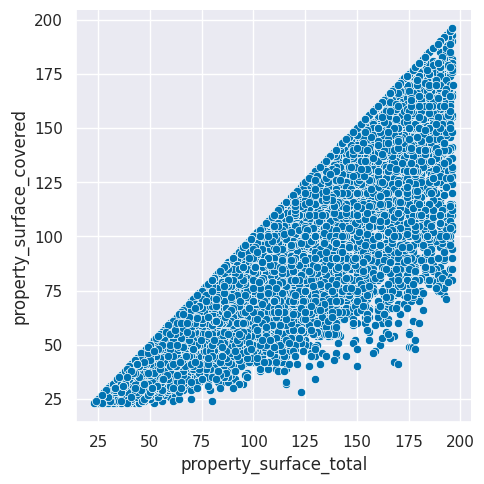

In [ ]:
sns.relplot(data=df_sin_outliers, x="property_surface_total", y="property_surface_covered", kind="scatter")

<Axes: ylabel='property_surface_total'>

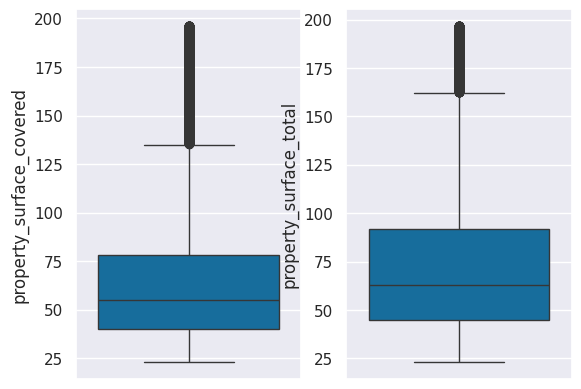

In [ ]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df_sin_outliers["property_surface_covered"], ax=ax[0])
sns.boxplot(y=df_sin_outliers["property_surface_total"], ax=ax[1])

[Text(0.5, 1.0, 'Correlación sin outliers')]

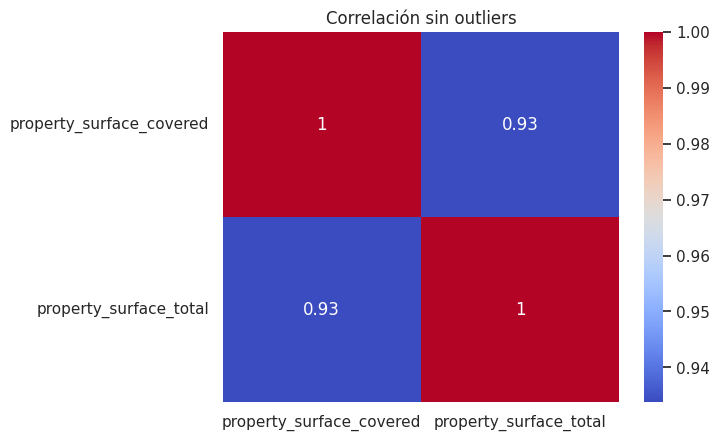

In [ ]:
corr = df_sin_outliers[["property_surface_covered", "property_surface_total"]].corr()
sns.heatmap(data=corr, annot=True, cmap="coolwarm").set(title="Correlación sin outliers")

[Text(0.5, 1.0, 'Correlación con outliers')]

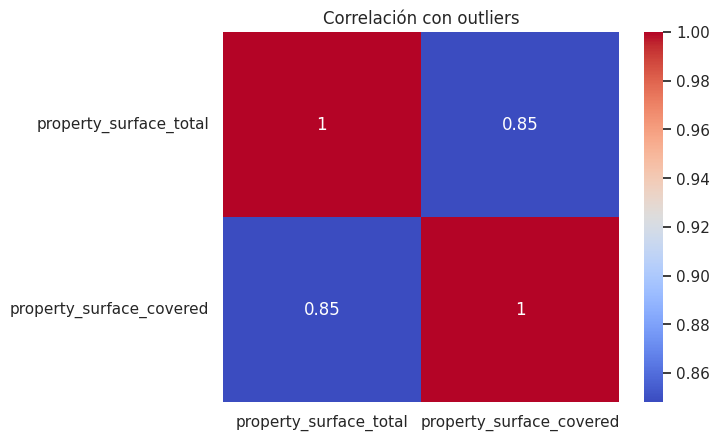

In [ ]:
corr = df[["property_surface_total", "property_surface_covered"]].corr()
sns.heatmap(data=corr, annot=True, cmap="coolwarm").set(title="Correlación con outliers")

In [ ]:
df = df_sin_outliers

#### Rooms y bedrooms

Nuevamente, utilizamos el método de imputación MICE.

In [ ]:
cantidad_rooms_na = len(df[df["property_rooms"].isna()])
cantidad_bedrooms_na = len(df[df["property_bedrooms"].isna()])

print("Cantidad con `property_rooms` nulo:", cantidad_rooms_na)
print("Cantidad con `property_bedrooms` nulo:", cantidad_bedrooms_na)

Cantidad con `property_rooms` nulo: 605
Cantidad con `property_bedrooms` nulo: 9644


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_rooms = IterativeImputer(random_state=0)
df.loc[:, ["property_rooms", "property_bedrooms"]] = impute_rooms.fit_transform(df[["property_rooms", "property_bedrooms"]])

Luego de imputar las filas nulas, tenemos que tomar en cuenta que los valores de estas columnas deben ser valores enteros, entonces decidimos redondear hacia arriba los valores flotantes que produjo la imputación.

In [ ]:
df[["property_rooms", "property_bedrooms"]] = df[["property_rooms", "property_bedrooms"]].transform(np.ceil)

Analizamos las estadísticas de ambas variables luego de la imputación.

In [ ]:
df[["property_rooms", "property_bedrooms"]].describe()

,property_rooms,property_bedrooms
count,83963.000000,83963.000000
mean,2.629325,1.766683
std,1.122297,0.916172
min,1.000000,-1.000000
25%,2.000000,1.000000
50%,3.000000,2.000000
75%,3.000000,2.000000
max,40.000000,70.000000


Podemos ver que hay algunas propiedades con cantidad de cuartos negativa, lo cual probablemente sea un error de tipeo por lo que su valor de `property_rooms` se asemeja a un valor esperable para una propiedad de 1 bedroom (que es el mismo valor ingresado pero sin el signo negativo). Además la descripción de esta propiedad indica que es un tres ambientes, por lo que los valores de 2 rooms y 1 bedroom encajan a la perfección. Decidimos corregirlo y mantener la fila.

In [ ]:
df[df["property_bedrooms"] == -1][["property_rooms", "property_bedrooms", "property_title"]]

,property_rooms,property_bedrooms,property_title
406880,2.0,-1.0,Jardines de Roosevelt - Hermoso 3 ambientes co...


In [ ]:
df.loc[406880, "property_bedrooms"] = 1

Visualizamos la relación entre ambas variables para encontrar outliers entre ellas.

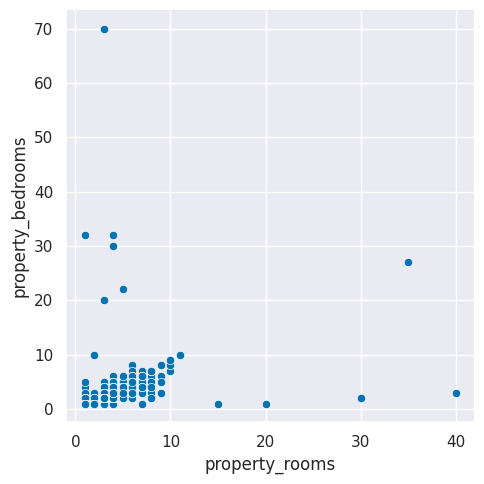

In [ ]:
sns.relplot(data=df, x="property_rooms", y="property_bedrooms", kind="scatter")

Este gráfico nos aporta información muy importante sobre los outliers en conjunto de estas dos variables. Acá podemos ver que los valores extremos de `property_rooms` y `property_bedrooms` no están tan relacionados, como sí sucedía con la áreas. Los valores extremos de `property_rooms` (salvo 1) no tienen un valor de `property_bedrooms` muy elevado, y viceversa.

Entonces analizamos los outliers de manera univariada.

<Axes: ylabel='property_bedrooms'>

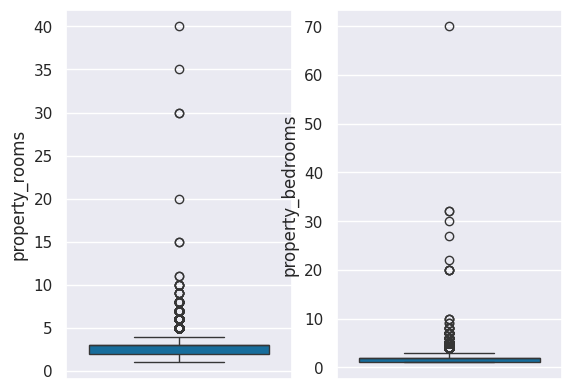

In [ ]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df["property_rooms"], ax=ax[0])
sns.boxplot(y=df["property_bedrooms"], ax=ax[1])

Observamos el resto de valores extremos de `property_bedrooms`.

In [ ]:
df[df["property_bedrooms"] > 15][["property_rooms", "property_bedrooms", "property_title"]]

,property_rooms,property_bedrooms,property_title
36421,3.0,20.0,Departamento - Palermo
48279,4.0,32.0,Departamento 4 ambientes a estrenar en duplex ...
49960,1.0,32.0,Depto 1 ambiente amplio apto profesional
86014,4.0,30.0,Departamento. Recoleta. Balcón terraza. Silenc...
94998,3.0,70.0,Departamento - Villa Luro
140832,5.0,22.0,Departamento de 2 dormitorios con balcón en ve...
150885,35.0,27.0,Venta Departamento monoambiente balcón full am...
337147,3.0,20.0,Excelente y único Departamento en duplex a nue...
337149,3.0,20.0,Excelente y único Departamento en duplex a nue...
337831,3.0,20.0,Excelente y único Departamento en duplex a nue...


Entre los registros observados, consideramos rescatables aquellos cuya descripción indica que son monoambientes y el en la que dice explícitamente que la propiedad tiene 2 dormitorios.

In [ ]:
df.loc[[49960, 150885], ["property_rooms", "property_bedrooms"]] = 1
df.loc[140832, "property_bedrooms"] = 2

Ahora observamos los valores extremos de `property_rooms`.

In [ ]:
df[df["property_rooms"] > 12][["property_rooms", "property_bedrooms", "property_title"]]

,property_rooms,property_bedrooms,property_title
21009,30.0,2.0,C/DEP COCH Y BAULERA - SEGUI AL 700 - Caballito
52157,30.0,2.0,PH - Parque Avellaneda
122415,15.0,1.0,PH - San Telmo
211468,20.0,1.0,Departamento - Puerto Madero
356618,40.0,3.0,SOLER 4400 - PALERMO - DPTO 4 AMB C/ BALCON AL...
436374,15.0,1.0,Departamento en venta de 37.20 m2 un ambiente...


Todos, salvo los que dicen que tienen 15 cuartos, podrían ser errores de tipeo, en los que se agregó un cero demás al ingresar los dígitos del valor real de `property_rooms`. Optamos por corregirlos y dropear los que tienen un valor de 15.

In [ ]:
df = df.drop([122415, 436374])
df.loc[df["property_rooms"] > 12, "property_rooms"] = df[df["property_rooms"] > 12]["property_rooms"] / 10

También nos interesa saber si hay propiedades con más bedrooms que rooms. Encontramos algunos registros con esta condición, pero como son pocos los dropeamos.

In [ ]:
len(df[df["property_rooms"] < df["property_bedrooms"]])

102

In [ ]:
df = df.drop(df[df["property_rooms"] < df["property_bedrooms"]].index)

Finalmente, al igual que a como hicimos con las variables de área, decimos dropear los outliers que la métrica de las distancia intercuartil considere como tales.

In [ ]:
q1 = df["property_rooms"].quantile(0.25)
q3 = df["property_rooms"].quantile(0.75)
iqr = q3 - q1
outliers_rooms = df["property_rooms"] > q3 + iqr * 1.5

q1 = df["property_bedrooms"].quantile(0.25)
q3 = df["property_bedrooms"].quantile(0.75)
iqr = q3 - q1
outliers_bedrooms = df["property_bedrooms"] > q3 + iqr * 1.5

df = df.drop(df[outliers_rooms | outliers_bedrooms].index)

Visualizamos como quedan las distribuciones conjuntas de estas variables y sus outliers. Como las cantidad de cuartos son variables discretas, utilizamos un gráfico de barras en vez de un scatterplot.

<Axes: xlabel='cantidad cuartos o dormitorios', ylabel='count'>

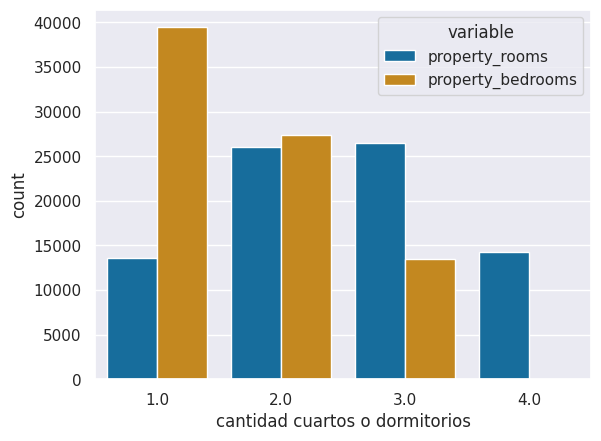

In [ ]:
df_long = pd.melt(df, value_vars=["property_rooms", "property_bedrooms"], var_name="variable", value_name="cantidad cuartos o dormitorios")
sns.countplot(data=df_long, x="cantidad cuartos o dormitorios", hue="variable")

<Axes: ylabel='property_bedrooms'>

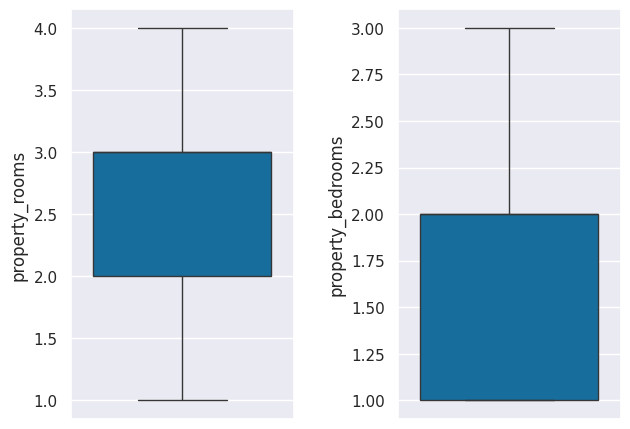

In [ ]:
fig, ax = plt.subplots(1, 2);
fig.tight_layout(w_pad=3)

sns.boxplot(y=df["property_rooms"], ax=ax[0])
sns.boxplot(y=df["property_bedrooms"], ax=ax[1])

# Agrupamiento

Para empezar con la sección de clustering, consideramos oportuno mostrar un gráfico con toda la data antes de ser dividida en clusters.

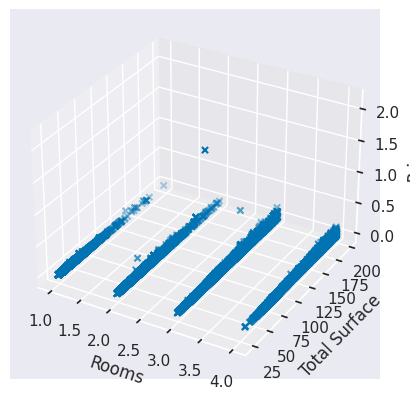

In [ ]:
def scatter_df(df):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  xs = df['property_rooms']
  ys = df['property_surface_total']
  zs = df['property_price']
  ax.scatter(xs, ys, zs, marker='x')

  ax.set_xlabel('Rooms')
  ax.set_ylabel('Total Surface')
  ax.set_zlabel('Price')

  plt.show()

scatter_df(df)

Se aprecia la presencia de dos outliers que distorsionan la visualización. Para evitar eso, dropeamos ambos.

In [ ]:
df.sort_values('property_price', ascending=False)

,id,start_date,end_date,latitud,longitud,neighbourhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
60073,uoM9HDKq3jZKQKgHXTIGkg==,2021-01-25,2022-05-13,-34.616044,-58.458621,Caballito,Departamento,3.0,2.0,68.000000,64.000000,21400000.0,Departamento venta
306829,nH/Kmmg1djAa7Wbrm742qA==,2021-03-04,2021-06-05,-34.616918,-58.359927,Puerto Madero,Departamento,3.0,2.0,128.000000,118.000000,7149999.0,Departamento - Puerto Madero
401318,2Z5VCCq2CSNrF2FcGJnWjg==,2021-06-17,2021-09-05,-34.551243,-58.455105,Nuñez,Departamento,2.0,1.0,56.000000,47.000000,2790000.0,Venta departamento 2 ambientes Nuñez Financio
3988,bMbo9CdhczvF3IY5329LVg==,2021-02-20,2021-09-11,-34.611004,-58.361275,Puerto Madero,Departamento,3.0,2.0,165.708979,140.000000,2000000.0,Departamento - Puerto Madero
422622,qBIrC1ZmRGzqVmhYcuTEsA==,2021-07-07,9999-12-31,-34.612665,-58.358798,Puerto Madero,Departamento,3.0,2.0,195.000000,195.000000,1990000.0,Departamento - Puerto Madero
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105866,M5IUi8ASsbZEycYtMbzxdw==,2021-03-11,2021-06-05,-58.421745,-34.609227,Almagro,Departamento,3.0,2.0,50.000000,47.541766,10000.0,COMPRAMOS PROPIEDADES EN EL ESTADO QUE SE ENCU...
170212,pcjSyDd82IYXeVAPrpXjyw==,2021-07-28,2021-07-30,-58.450241,-34.554763,Belgrano,Departamento,3.0,2.0,50.000000,47.541766,10000.0,Tus Contactos Valen Recomendanos Gente y Gana ...
140460,u8oPwCg2R/C105SlZ9nlaQ==,2021-12-08,2022-01-27,-34.579756,-58.406144,Palermo,Departamento,3.0,2.0,120.000000,110.000000,7500.0,Departamento - Palermo
264963,CmmjZYus9eLZAT1UMsuaSQ==,2021-11-19,9999-12-31,-34.598361,-58.387041,Recoleta,Departamento,1.0,1.0,35.000000,35.000000,6500.0,Departamento venta


In [ ]:
df = df.drop([60073, 306829])

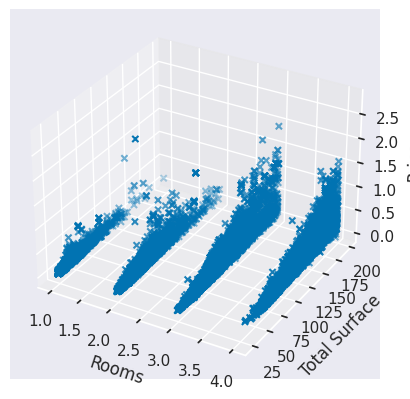

In [ ]:
scatter_df(df)

### Tendencia al clustering

KMeans encuentra clusters incluso en datos con una distribución uniforme, con lo cual usarlo sin un previo análisis de la tendencia al clustering del dataset no tendría mucho sentido, porque los grupos no significarían nada. Para hacer este análisis, usamos la estadística de Hopkins.

Necesitamos quedarnos con las columnas numéricas del dataframe para que la función no tenga problemas con los valores no numéricos. También, exceptuamos la latitud y la longitud para quedarnos con variables que puedan ser facilmente comparables.

In [ ]:
print(format(hopkins(df[['property_rooms', 'property_surface_total', 'property_price']],df.shape[0]), 'f'))

0.000276


En la implementación de la librería `pyclustertend` se indica que, usando el método `hopkins`, un valor más cercano a 0 implica una mayor tendencia a la clusterización. En nuestro caso, se puede ver una fuerte tendencia al clustering, con lo cual podemos proceder a usar KMeans para encontrar clusters en nuestro dataset.

### Cantidad óptima de grupos

Para evaluar la cantidad óptima de grupos que se deben formar, aplicamos KMeans varias veces y calculamos el coeficiente de Silhouette promedio de toda la muestra en cada ocasión.


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

lista_distintos_k = range(2, 10)
data = df[['property_rooms', 'property_surface_total', 'property_price']]

for n_clusters in lista_distintos_k:
  clusterer = KMeans(n_clusters=n_clusters, n_init='auto')
  preds = clusterer.fit_predict(data)
  score = silhouette_score(data, preds)
  print("Para n_clusters=" + str(n_clusters) + ", el score de silhouette es " + str(score))

Para n_clusters=2, el score de silhouette es 0.7447721120716269
Para n_clusters=3, el score de silhouette es 0.6566583839009847
Para n_clusters=4, el score de silhouette es 0.5979246727149722
Para n_clusters=5, el score de silhouette es 0.5680402883236632
Para n_clusters=6, el score de silhouette es 0.5635390214603851
Para n_clusters=7, el score de silhouette es 0.5546100524244971
Para n_clusters=8, el score de silhouette es 0.5575783417181344
Para n_clusters=9, el score de silhouette es 0.5518747786703864


Nos quedamos con dos grupos, que es la cantidad cuyo coeficiente de Silhouette es el más cercano a 1. Pareciera que a medida que intentamos con más grupos, el coeficiente cae.

Entonces, aplicamos KMeans para que encuentre dos clusters en nuestro dataframe, y lo graficamos.

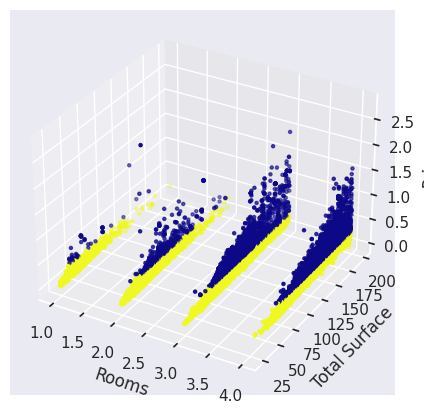

In [ ]:
CANTIDAD_OPTIMA_DE_CLUSTERS = 2
COLORES = 'plasma'

def kmean_scatter_plot(df=None, clusters=2, elev=None, axim=None, roll=None):
  labels = KMeans(clusters, random_state=0, n_init='auto').fit_predict(df[['property_rooms', 'property_surface_total', 'property_price']])

  fig = plt.figure(figsize=(5,5))

  ax = fig.add_subplot(projection='3d')
  ax.view_init(elev=elev, azim=axim, roll=roll)

  xs = df['property_rooms']
  ys = df['property_surface_total']
  zs = df['property_price']
  ax.scatter(xs, ys, zs, marker='.', c=labels, cmap=COLORES)

  ax.set_xlabel('Rooms')
  ax.set_ylabel('Total Surface')
  ax.set_zlabel('Price')

  plt.show()

kmean_scatter_plot(df, CANTIDAD_OPTIMA_DE_CLUSTERS)

Acomodamos un poco el ángulo para poder ver los clusters con más claridad.

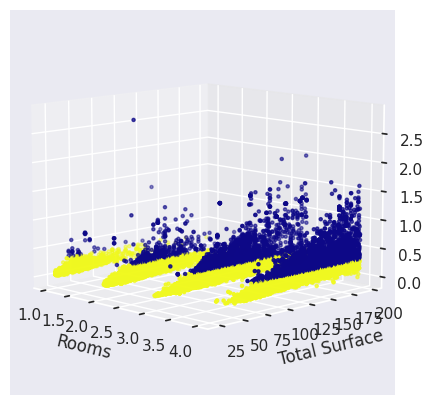

In [ ]:
kmean_scatter_plot(df, CANTIDAD_OPTIMA_DE_CLUSTERS, 10, -45, 0)

Parecería como que la variable más significativa fue el precio. Viendo el scatterplot desde un lado, se ve una clara división a partir de ciertos precios, como si hubiese un plano prácticamente horizontal que corta la data.

### Datos sobre mapa de CABA

Si graficaramos estos datos sobre un mapa, por como quedaron formados los clusters, podríamos ver como se reparten los precios de las viviendas en las diferentes zonas de CABA.

Para poder hacer esto, primero hay que verificar que los datos de latitudes y longitudes sean correctos. Para eso, hacemos un boxplot de cada uno.

<Axes: ylabel='longitud'>

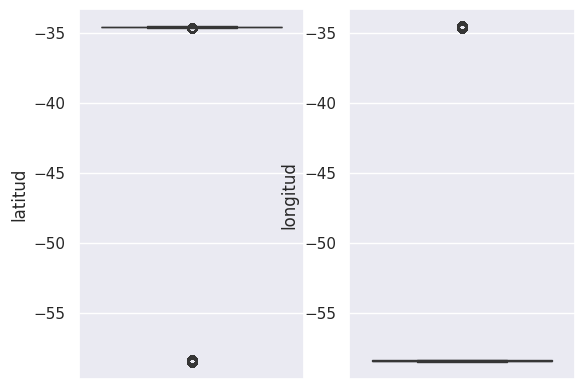

In [ ]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df["latitud"], ax=ax[0])
sns.boxplot(y=df["longitud"], ax=ax[1])

Ambos boxplots muestran grupos de outliers muy definidos. Lo curioso es que los outliers de uno parecen ubicarse en los valores donde se encuentra el promedio del otro. Esto pareciera indicar que la latitud y la longitud en los outliers están invertidas. Con lo cual, procedemos a acomodar esos datos.

<Axes: ylabel='longitud'>

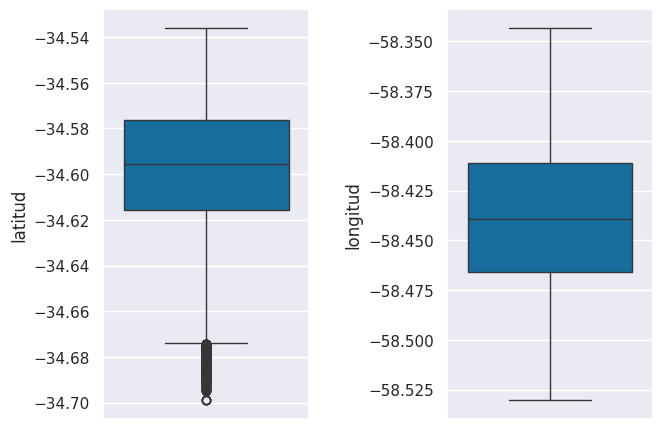

In [ ]:
latitudes_errones = df['latitud'] < -50

longitudes = df[latitudes_errones]['longitud']
df.loc[latitudes_errones, 'longitud'] = df[df['latitud'] < -50]['latitud']
df.loc[latitudes_errones, 'latitud'] = longitudes

longitudes_erroneas = df['longitud'] > -55

latitudes = df[longitudes_erroneas]['latitud']
df.loc[longitudes_erroneas, 'latitud'] = df[df['latitud'] < -50]['longitud']
df.loc[longitudes_erroneas, 'longitud'] = latitudes

fig, ax = plt.subplots(1, 2)
fig.tight_layout(w_pad=5)

sns.boxplot(y=df["latitud"], ax=ax[0])
sns.boxplot(y=df["longitud"], ax=ax[1])

Volvemos a mostrar los boxplots y vemos que ahora se ven mejor, con lo cual podemos graficar los anuncios sobre un mapa de CABA.

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'Propiedades en venta - CABA')

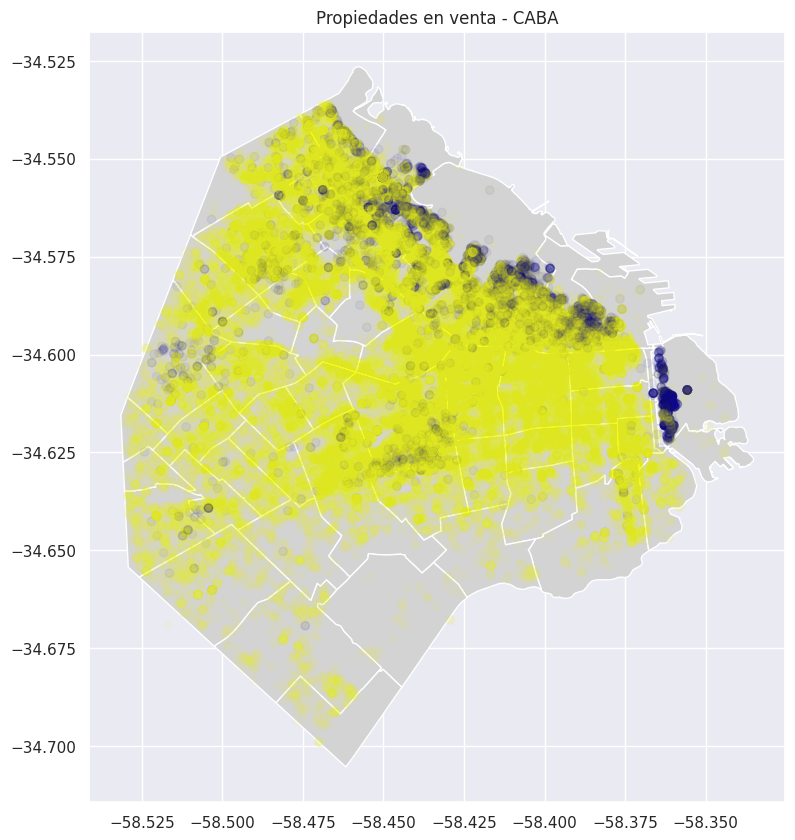

In [ ]:
labels = KMeans(2, random_state=0, n_init='auto').fit_predict(df[['property_rooms', 'property_surface_total', 'property_price']])
clustered_df = df.assign(cluster=labels)

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['longitud'], df['latitud'])]
geo_df = gpd.GeoDataFrame(clustered_df,
                          crs = crs,
                          geometry = geometry)

fig, ax = plt.subplots(figsize = (10,10))
caba_map.plot(ax=ax, color='lightgrey')
geo_df.plot(column='cluster', ax=ax, alpha=.05, cmap=COLORES)
ax.set_title('Propiedades en venta - CABA')

En el mapa, se ve que el grupo de anuncios de propiedades con menores precios está repartido por toda la ciudad, mientras que el otro se encuentra bastante concentrado en 5 barrios: Puerto Madero, Retiro, Recoleta, Palermo y Belgrano.

Otro dato no menor es que hay grandes zonas de CABA con una muy baja densidad de anuncios, como en Villa Ligano, Villa Soldati y Villa Riachuelo, y una pequeña zona en Agronomía, La Paternal y Chacarita.

### Con tres grupos

Si aplicamos KMeans con 3 clusters, esa mayor cantidad de clusters nos va a permitir, una vez graficados los anuncios sobre el mapa, hacer observaciones un poco más precisas.

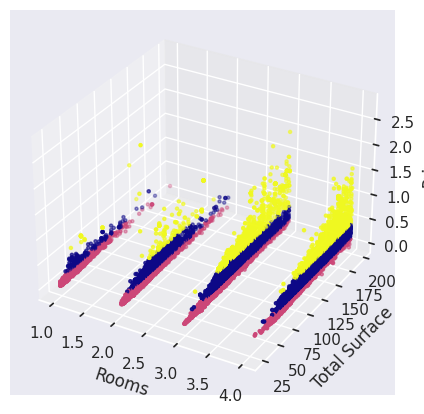

In [ ]:
kmean_scatter_plot(df, 3)

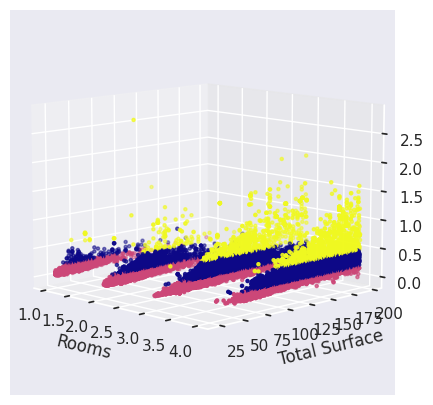

In [ ]:
kmean_scatter_plot(df, 3, 10, -45, 0)

Con tres grupos, parecería suceder el mismo fenómeno anterior: los grupos se forman, principalmente, en función del precio de los anuncios.

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'Propiedades en venta - CABA')

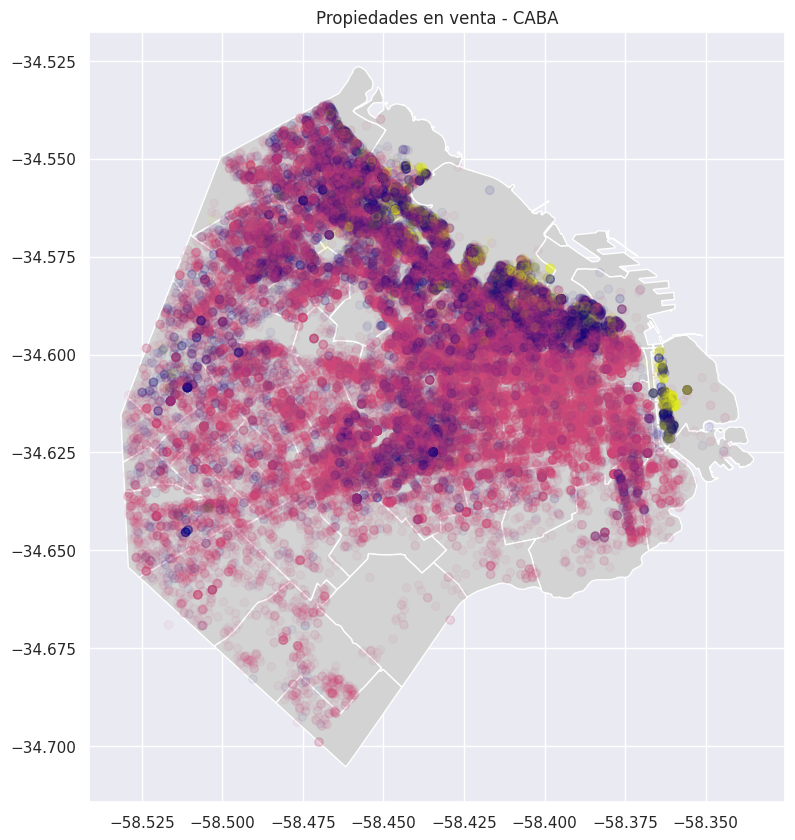

In [ ]:
labels = KMeans(3, random_state=0, n_init='auto').fit_predict(df[['property_rooms', 'property_surface_total', 'property_price']])
clustered_df = df.assign(cluster=labels)

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['longitud'], df['latitud'])]
geo_df = gpd.GeoDataFrame(clustered_df,
                          crs = crs,
                          geometry = geometry)

fig, ax = plt.subplots(figsize = (10,10))
caba_map.plot(ax=ax, color='lightgrey')
geo_df.plot(column='cluster', ax=ax, alpha=.05, cmap=COLORES)
ax.set_title('Propiedades en venta - CABA')

Como ahora disponemos de tres grupos de precios, podemos distinguir zonas en donde los anuncios tienen un precio intermedio, ni muy alto ni muy bajo. Entre ellas, se destacan Caballito y Almagro.

También, se puede ver que en las zonas con los precios más altos, hay mayor cantidad de anuncios con precios intermedios que en el resto de los barrios.